In [1]:
import torch
import torch.nn as nn
import numpy as np
import os 
from IPython.display import Image
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision 
import cv2 as cv
import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from torch.utils.data import TensorDataset
from PIL import Image
from torch.utils.data import DataLoader
import os, zipfile, shutil, PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from time import sleep
from tqdm import tqdm
import random
import itertools

In [2]:
Main_Path = 'E:\\Projekt'

In [3]:
image_path = os.path.join(Main_Path, 'CNN_Letter')

In [4]:
dir_path = image_path
digits = sorted(os.listdir(dir_path))
print(digits)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
digits_counter = {}
NUM_IMAGES = 0

for digit in digits:
    path = os.path.join(dir_path, digit)
    digits_counter[digit] = len(os.listdir(path))
    NUM_IMAGES += len(os.listdir(path))

print(digits_counter)
print('Number of all images: ', NUM_IMAGES)

{'0': 1030, '1': 1030, '2': 1030, '3': 1030, '4': 1030, '5': 1030, '6': 1030, '7': 1030, '8': 1030, '9': 1030, 'A': 1010, 'B': 1030, 'C': 1020, 'D': 1010, 'E': 1010, 'F': 1020, 'G': 1020, 'H': 1020, 'I': 1010, 'J': 1030, 'K': 1010, 'L': 1010, 'M': 1020, 'N': 1020, 'P': 1010, 'Q': 1010, 'R': 1020, 'S': 1020, 'T': 1020, 'U': 1010, 'V': 1030, 'W': 1010, 'X': 1010, 'Y': 1010, 'Z': 810}
Number of all images:  35500


In [6]:
dataset = datasets.ImageFolder(dir_path ,  transforms.Compose([
    transforms.Resize((96,96)),transforms.ToTensor()
]))

In [7]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Label : 0


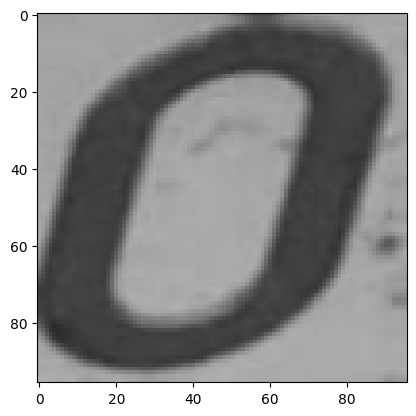

In [8]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0),cmap='gray')

display_img(*dataset[500])

In [9]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 128
val_size = 5000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True)
val_dl = DataLoader(val_data, batch_size)

Length of Train Data : 30500
Length of Validation Data : 5000


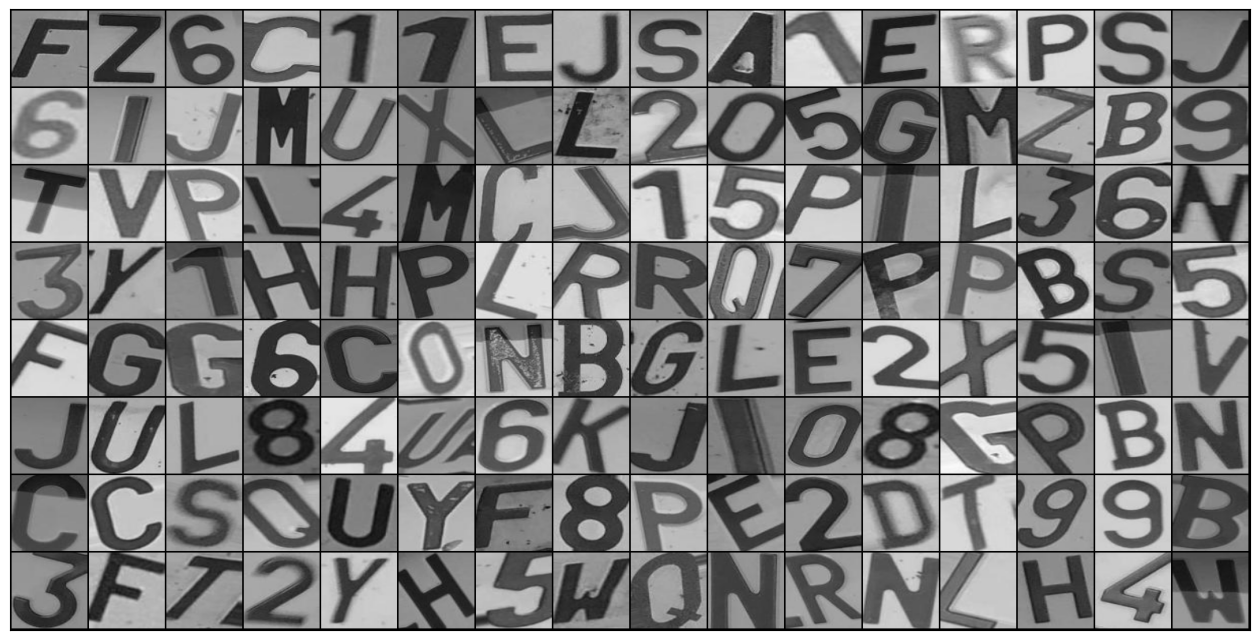

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [14]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [20]:
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(800, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 35)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.2)
        self.MaxPool = nn.MaxPool2d(kernel_size=3)
        self.flatten = nn.Flatten()

    def forward(self, out):
        out = self.conv1(out)
        out = self.relu(out)
        out = self.MaxPool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.MaxPool(out)
        out = self.flatten(out)
        
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
         

In [21]:
device = torch.device("cuda")

In [22]:
torch.manual_seed(1)
learning_rates = [0.1,0.01,0.001,0.0001]
num_epochs=30

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\Jakub\.conda\envs\SNIDL_Projekt\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 30/30 [13:00<00:00, 26.01s/it]


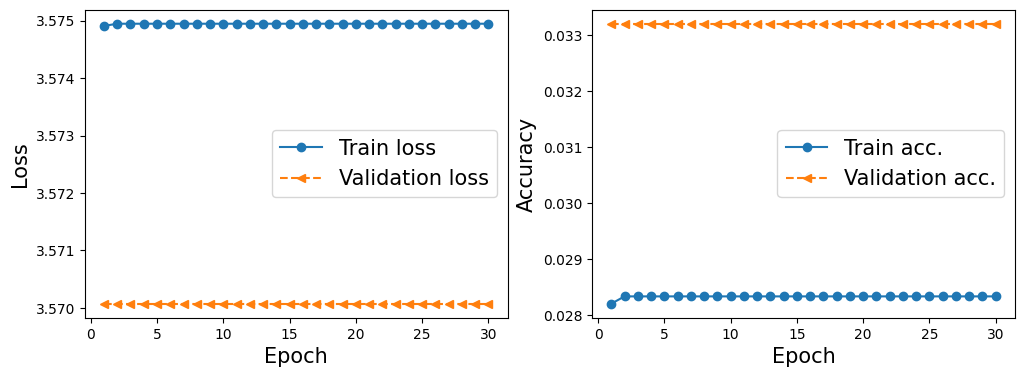

100%|██████████| 30/30 [10:47<00:00, 21.59s/it]


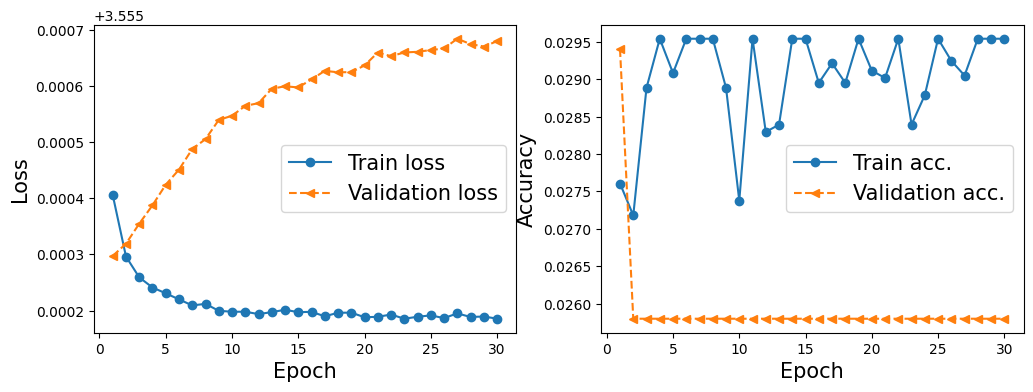

100%|██████████| 30/30 [10:41<00:00, 21.39s/it]


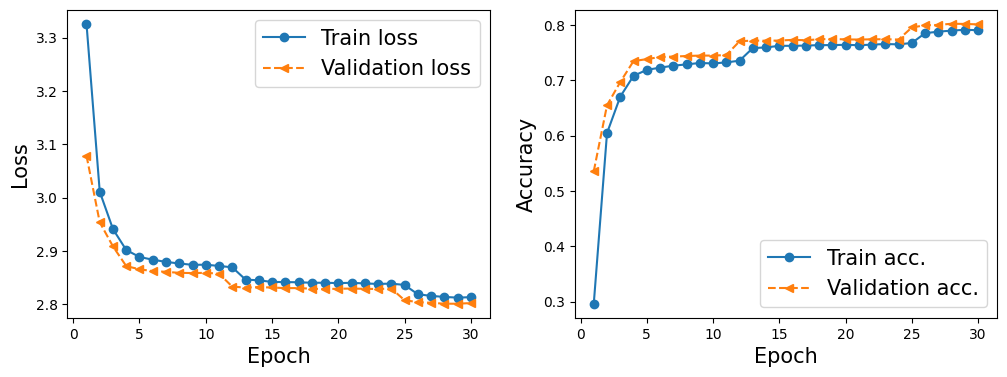

100%|██████████| 30/30 [10:35<00:00, 21.17s/it]


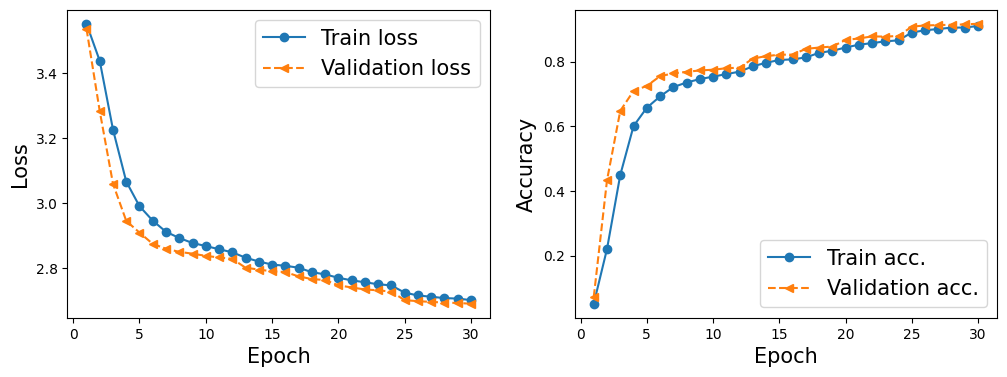

In [23]:
for learning_rate in learning_rates:
    model = Model_1()
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    hist = train(model, num_epochs, train_dl, val_dl)

    x_arr = np.arange(len(hist[0])) + 1  
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15) 
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    
    #plt.savefig('figures/14_13.png')
    plt.show()

In [26]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=2)
        self.fc1 = nn.Linear(256, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 35)
        self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(p=0.2)
        self.MaxPool = nn.MaxPool2d(kernel_size=3)
        self.flatten = nn.Flatten()

    def forward(self, out):
        out = self.conv1(out)
        out = self.relu(out)
        out = self.MaxPool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.MaxPool(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.MaxPool(out)

        
        out = self.flatten(out)
        
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.softmax(out)
        return out
         

100%|██████████| 30/30 [10:49<00:00, 21.63s/it]


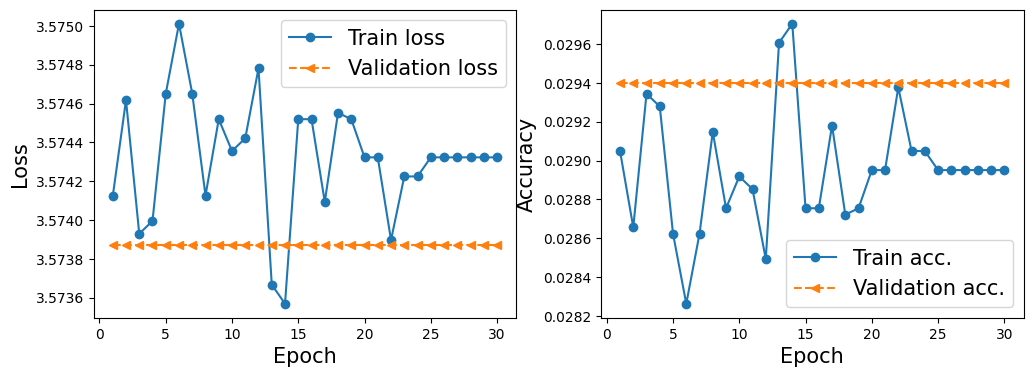

100%|██████████| 30/30 [11:15<00:00, 22.52s/it]


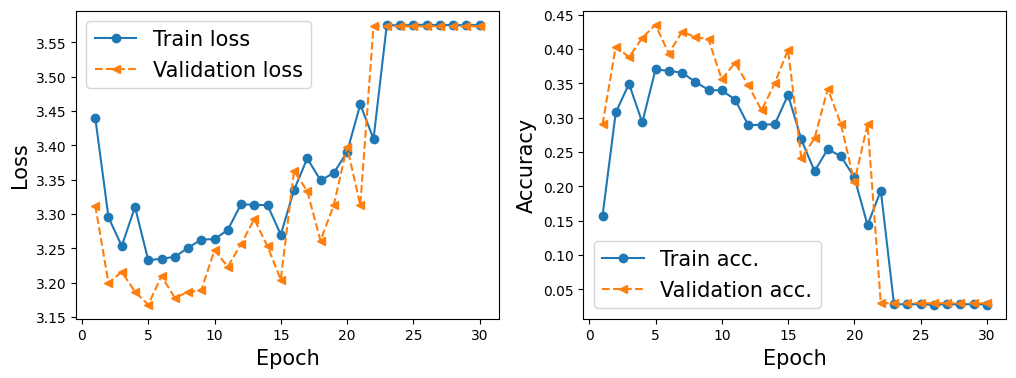

100%|██████████| 30/30 [11:20<00:00, 22.67s/it]


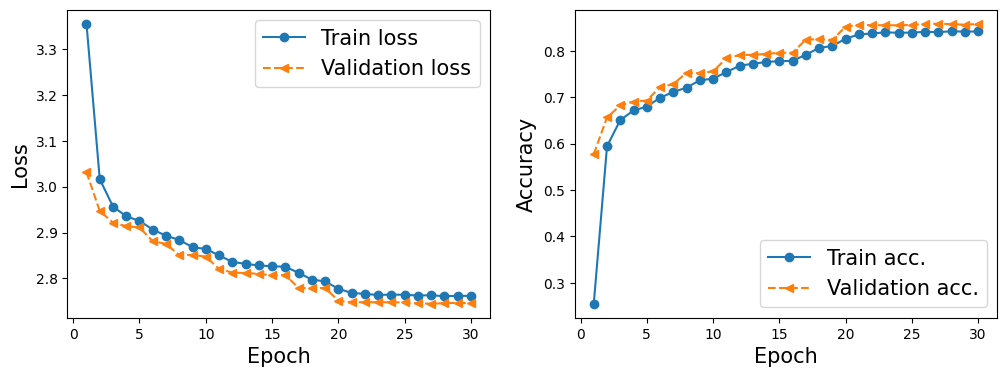

100%|██████████| 30/30 [10:41<00:00, 21.37s/it]


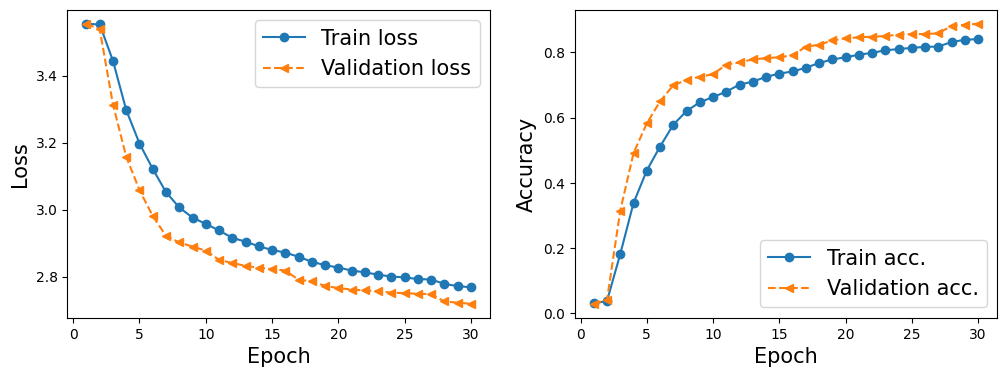

In [27]:
for learning_rate in learning_rates:
    model = Model_2()
    model.to("cuda")
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
    hist = train(model, 30, train_dl, val_dl)

    x_arr = np.arange(len(hist[0])) + 1  
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15) 
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    
    #plt.savefig('figures/14_13.png')
    plt.show()

#### Póki co wniosek jest taki - duży $\textit{learning \_ rate}$ nie jest specjalnie dobrym wyborem. W poniższej części przyjmiemy $lr=0.001$ na start. Jeśli jakiś model przykuje naszą uwagę to przetestujemy różne $\textit{lr}$. Oczywiście, z pewnością modele które otrzymamy niżej mogłyby działać dobrze dla innych learning_rate. 

In [111]:
class Model_3(nn.Module):
    def __init__(self, num_neurons = [128,128,128], dropout_rate = [0.5,0.5,0.5], channels = [8,8,16], paddings = [2,2,2]):
        super().__init__()



        ## Tworzymy wszystkie trzyelementowe ciągi dla warstw konwolucyjnych, dropout rate oraz liczby neuronów w warstwach linowych oraz padding
        all_possible_layers_neurons = list(itertools.combinations_with_replacement(num_neurons,3))
        all_possible_dropout_rates = list(itertools.combinations_with_replacement(dropout_rate,3))
        all_possible_channel_num = list(itertools.combinations_with_replacement(channels,3))
        all_possible_paddings = list(itertools.combinations_with_replacement(paddings,3))
        ## Losujemy jeden konkretny zestaw
        Neurons_in_given_layer_randomized = random.choices(all_possible_layers_neurons)
        Dropout_randomized = random.choices(all_possible_dropout_rates)
        Convolution_sizes_randomized = random.choices(all_possible_channel_num)      
        Padding_randomized = random.choices(all_possible_paddings)
        

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=Convolution_sizes_randomized[0][0], kernel_size=3, padding=Padding_randomized[0][0])
        self.conv2 = nn.Conv2d(in_channels=Convolution_sizes_randomized[0][0], out_channels=Convolution_sizes_randomized[0][1], kernel_size=3, padding=Padding_randomized[0][1])
        self.conv3 = nn.Conv2d(in_channels=Convolution_sizes_randomized[0][1], out_channels=Convolution_sizes_randomized[0][2], kernel_size=3, padding=Padding_randomized[0][2])
        self.MaxPool = nn.MaxPool2d(kernel_size=3)

        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.lazylinear = nn.LazyLinear(Neurons_in_given_layer_randomized[0][0])
        self.fc1 = nn.Linear(Neurons_in_given_layer_randomized[0][0], Neurons_in_given_layer_randomized[0][1])
        self.fc2 = nn.Linear(Neurons_in_given_layer_randomized[0][1], Neurons_in_given_layer_randomized[0][2])
        self.fc3 = nn.Linear(Neurons_in_given_layer_randomized[0][2], 35)
        self.softmax = nn.Softmax()      

        
        self.dropout1 = nn.Dropout(Dropout_randomized[0][0])
        self.dropout2 = nn.Dropout(Dropout_randomized[0][1])
        self.dropout3 = nn.Dropout(Dropout_randomized[0][2])
        

        self.parameters_randomized = [Neurons_in_given_layer_randomized, Dropout_randomized, Convolution_sizes_randomized, Padding_randomized]

    def forward(self, out):
        out = self.conv1(out)
        out = self.relu(out)
        out = self.MaxPool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.MaxPool(out)
        out = self.conv3(out)
        out = self.relu(out)
        out = self.MaxPool(out)

        
        out = self.flatten(out)
        out = self.lazylinear(out)    
        
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.relu(out)
        
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.dropout3(out)
        out = self.fc3(out)
        out = self.softmax(out)
        
        return out
         

In [239]:
dropout_rates = [0.2, 0.4, 0.6,0.8]
num_neurons = [16,64,96,128]
num_channels = [6,8,10,12]
paddings = [1,2]
num_epochs=10

#### Przeszukujemy losowe modele w celu znalezienia takiego który mógłby być obiecujący i zdatny do poprawy. W $\textit{"Model 3"}$ Losujemy ze zwracaniem parametry $\textit{dropout}$, $\textit{out\_ channels}$, $\textit{padding}$ oraz ilość neuronów w warstwach liniowych. \\
#### Z pomocą polecenia $\textit{model.parameters{\_}randomized}$ możemy sprawdzić te wylosowane parametry. Szukamy w tym wypadku na oślep żeby wiedzieć w którym kierunku isć


100%|██████████| 10/10 [02:34<00:00, 15.45s/it]

Parametry modelu: [[(64, 64, 64)], [(0.4, 0.6, 0.6)], [(8, 8, 10)], [(2, 2, 2)], [3]]


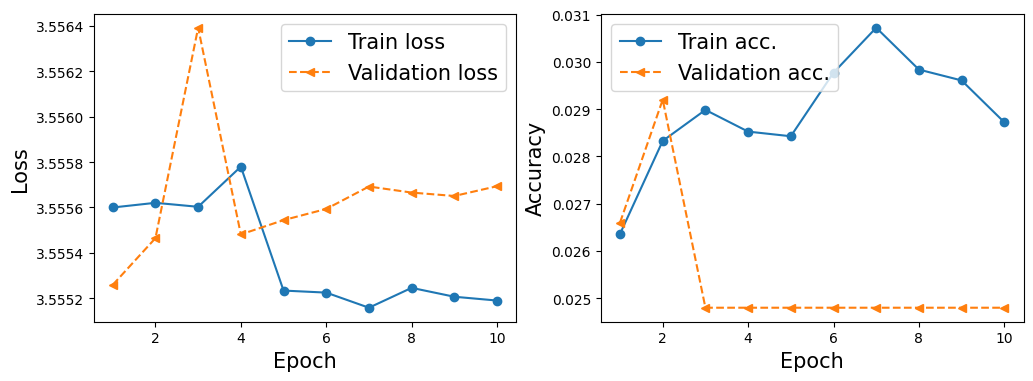

100%|██████████| 10/10 [02:39<00:00, 15.97s/it]

Parametry modelu: [[(64, 96, 128)], [(0.4, 0.8, 0.8)], [(6, 6, 12)], [(2, 2, 2)], [3]]


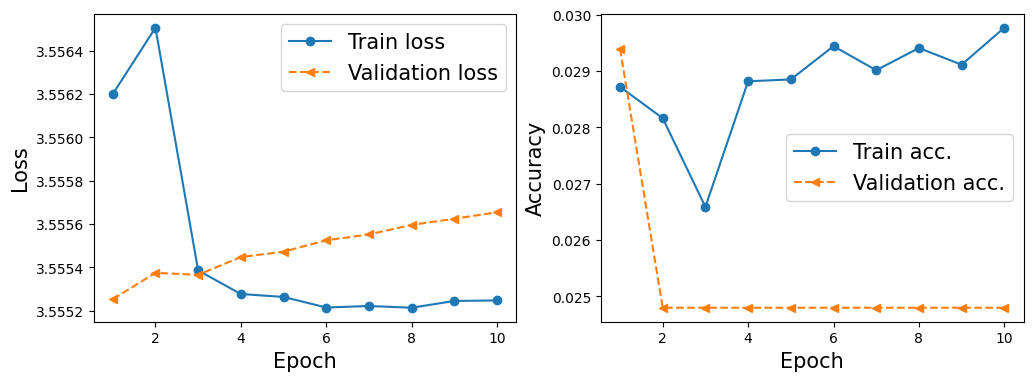

100%|██████████| 10/10 [02:34<00:00, 15.43s/it]

Parametry modelu: [[(96, 128, 128)], [(0.2, 0.2, 0.2)], [(8, 8, 8)], [(1, 1, 2)], [3]]


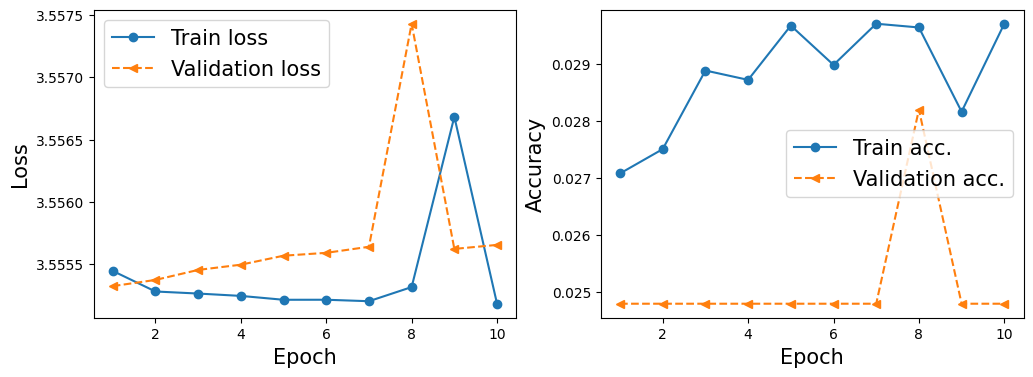

100%|██████████| 10/10 [02:35<00:00, 15.53s/it]


Parametry modelu: [[(16, 16, 128)], [(0.2, 0.4, 0.4)], [(6, 8, 12)], [(1, 2, 2)], [3]]


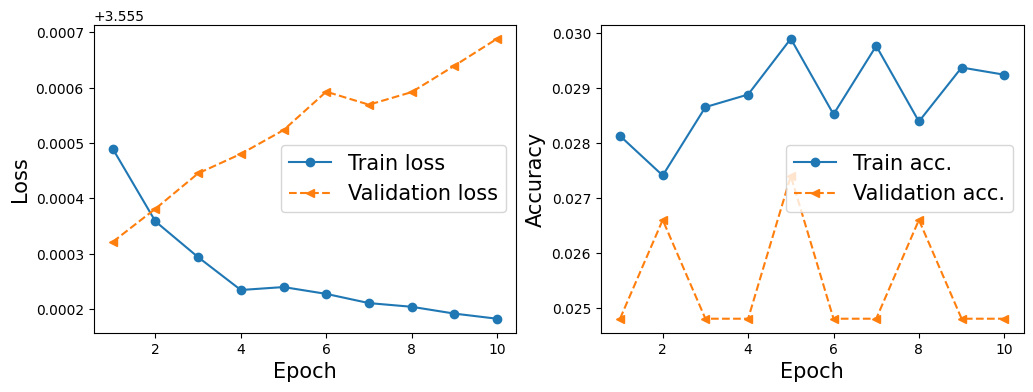

100%|██████████| 10/10 [02:40<00:00, 16.02s/it]

Parametry modelu: [[(64, 64, 128)], [(0.2, 0.2, 0.6)], [(6, 6, 8)], [(1, 1, 2)], [3]]


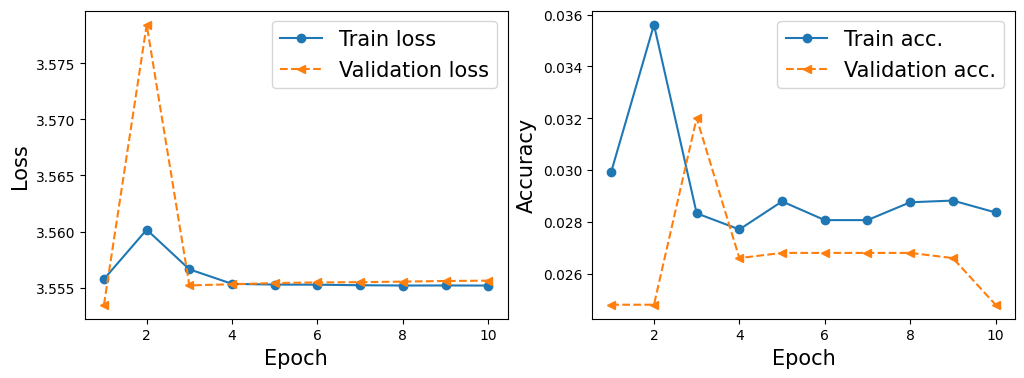

100%|██████████| 10/10 [02:36<00:00, 15.65s/it]

Parametry modelu: [[(64, 64, 128)], [(0.4, 0.4, 0.6)], [(8, 8, 8)], [(1, 1, 1)], [3]]


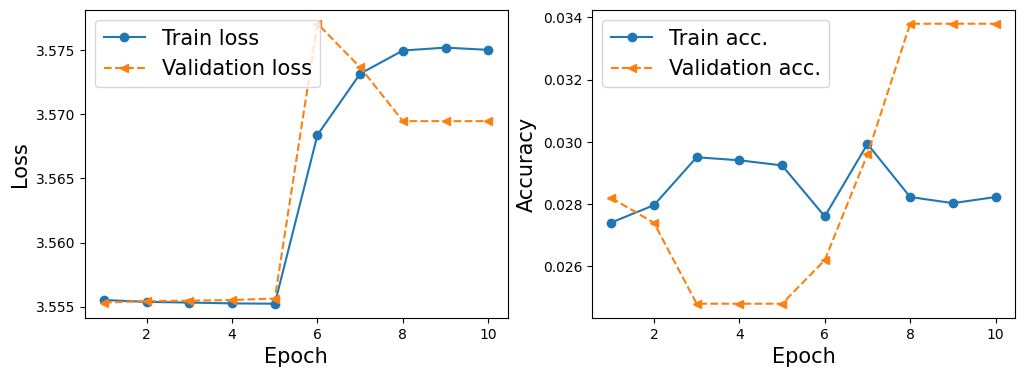

100%|██████████| 10/10 [02:39<00:00, 15.94s/it]

Parametry modelu: [[(96, 128, 128)], [(0.2, 0.6, 0.6)], [(6, 6, 10)], [(1, 1, 2)], [3]]


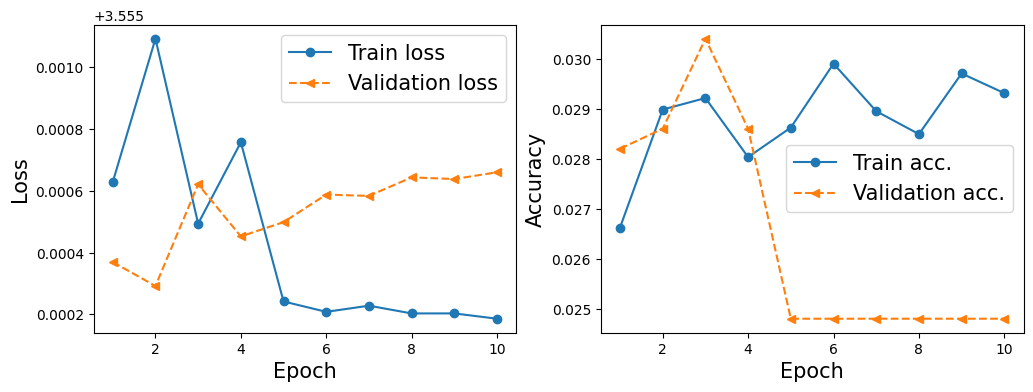

100%|██████████| 10/10 [02:36<00:00, 15.63s/it]


Parametry modelu: [[(96, 128, 128)], [(0.6, 0.8, 0.8)], [(8, 8, 8)], [(1, 2, 2)], [3]]


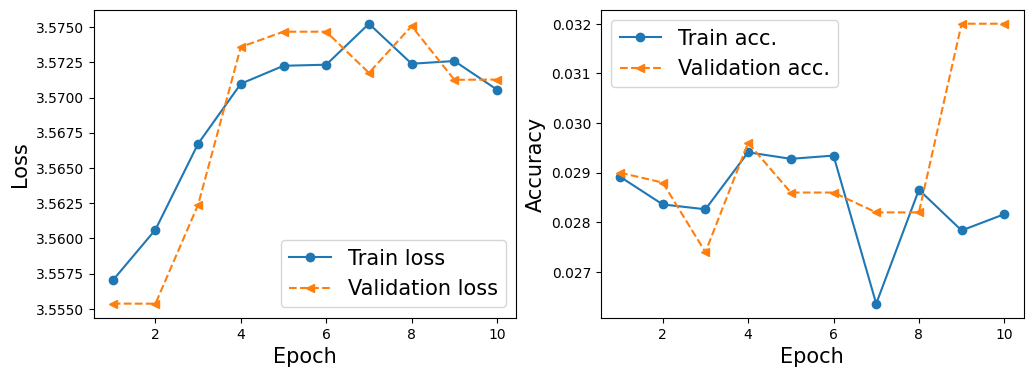

100%|██████████| 10/10 [02:43<00:00, 16.34s/it]

Parametry modelu: [[(64, 96, 96)], [(0.2, 0.8, 0.8)], [(8, 8, 8)], [(2, 2, 2)], [3]]


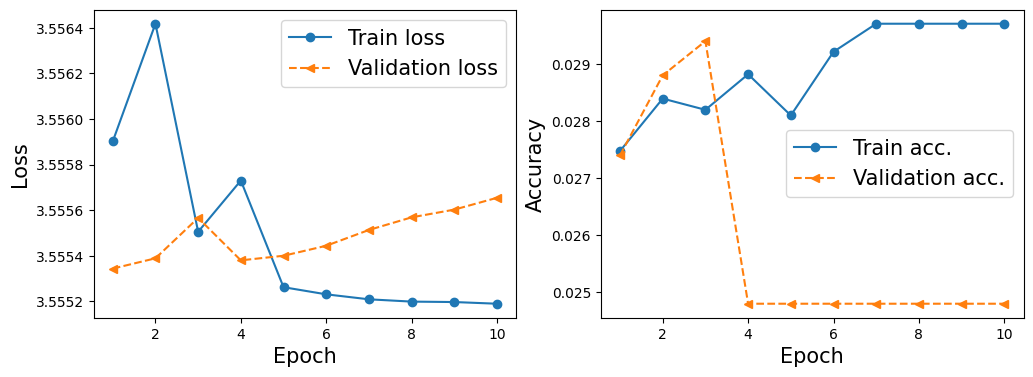

100%|██████████| 10/10 [02:44<00:00, 16.42s/it]

Parametry modelu: [[(16, 96, 128)], [(0.4, 0.4, 0.6)], [(8, 8, 12)], [(1, 2, 2)], [3]]


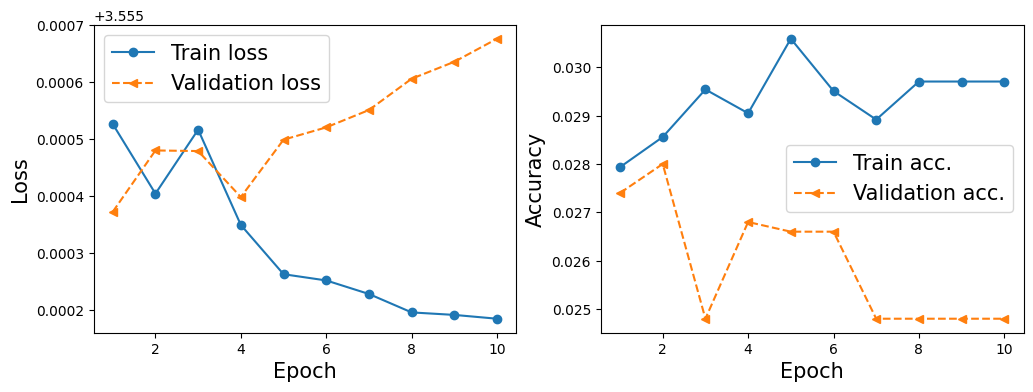

In [240]:
for i in range(10):
    model = Model_3(num_neurons, dropout_rates, num_channels, paddings)
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
    hist = train(model, num_epochs, train_dl, val_dl)

    x_arr = np.arange(len(hist[0])) + 1  
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15) 
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    print(f'Parametry modelu: {model.parameters_randomized}')

    

    plt.show()

#### No i nic nie znaleźliśmy. Wcześniejsze modele dobrze się uczyły dla $\textit{lr} = 0.001$, więc taki parametr sprawdzimy.

100%|██████████| 10/10 [02:32<00:00, 15.29s/it]

Parametry modelu: [[(128, 128, 128)], [(0.2, 0.2, 0.2)], [(6, 6, 6)], [(2, 2, 2)]]


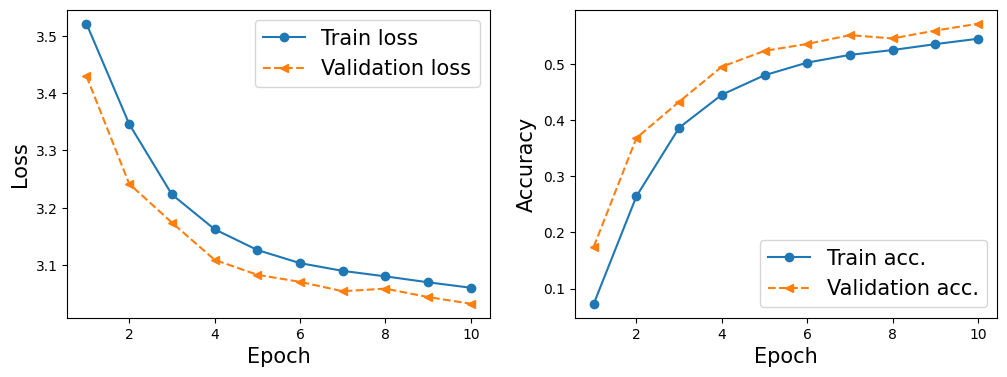

In [112]:
for i in range(1):
    model = Model_3([128], [0.2], [6], [2])
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    hist = train(model, 10, train_dl, val_dl)

    x_arr = np.arange(len(hist[0])) + 1  
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15) 
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    print(f'Parametry modelu: {model.parameters_randomized}')

    

    plt.show()

#### Wniosek jest taki, że szukamy raczej większej sieci niż mniejszej

In [243]:
dropout_rates = [0.2, 0.4, 0.6,0.8]
num_neurons = [96,128,192]
num_channels = [12,14,16]
paddings = [1,2]
num_epochs=10

100%|██████████| 10/10 [02:49<00:00, 16.95s/it]

Parametry modelu: [[(96, 96, 192)], [(0.2, 0.4, 0.4)], [(12, 14, 14)], [(1, 2, 2)], [3]]


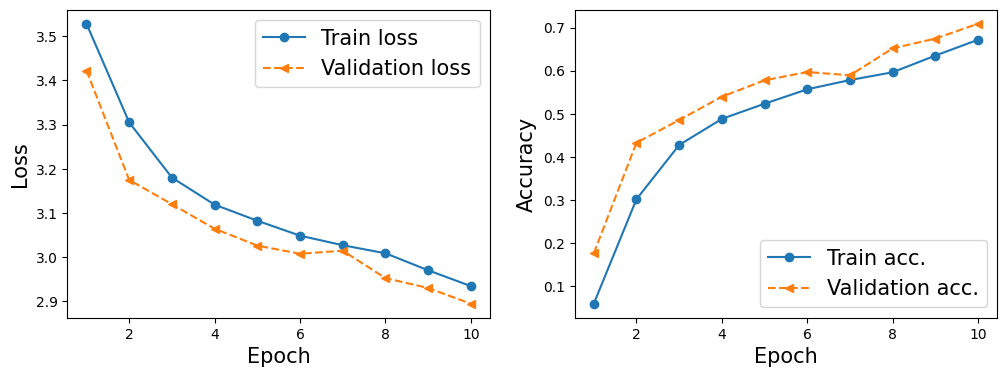

100%|██████████| 10/10 [03:54<00:00, 23.42s/it]


Parametry modelu: [[(192, 192, 192)], [(0.2, 0.2, 0.4)], [(12, 12, 16)], [(1, 1, 1)], [3]]


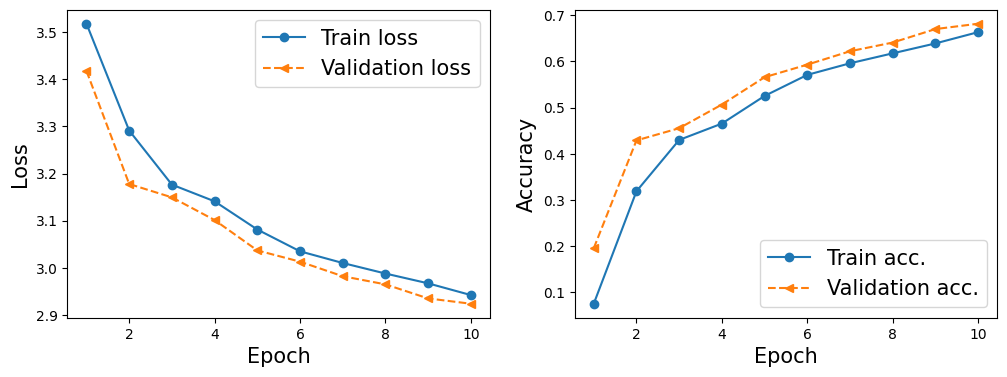

100%|██████████| 10/10 [03:23<00:00, 20.38s/it]


Parametry modelu: [[(128, 128, 192)], [(0.2, 0.2, 0.8)], [(16, 16, 16)], [(1, 1, 2)], [3]]


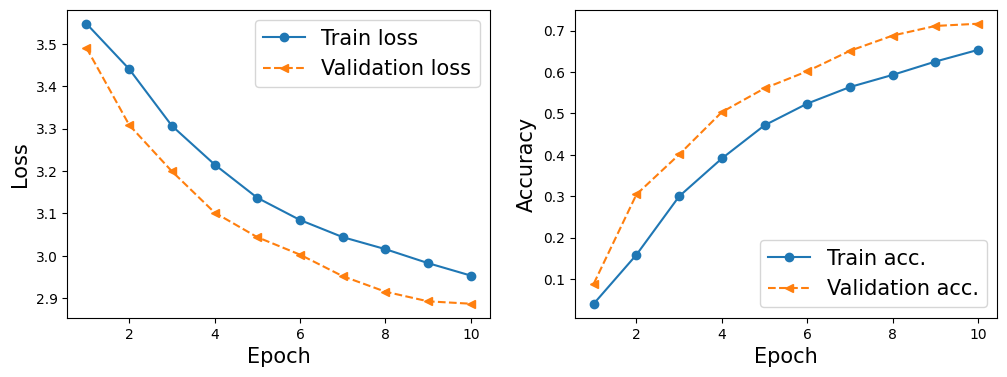

100%|██████████| 10/10 [02:38<00:00, 15.85s/it]


Parametry modelu: [[(96, 96, 96)], [(0.4, 0.4, 0.8)], [(12, 14, 14)], [(1, 1, 2)], [3]]


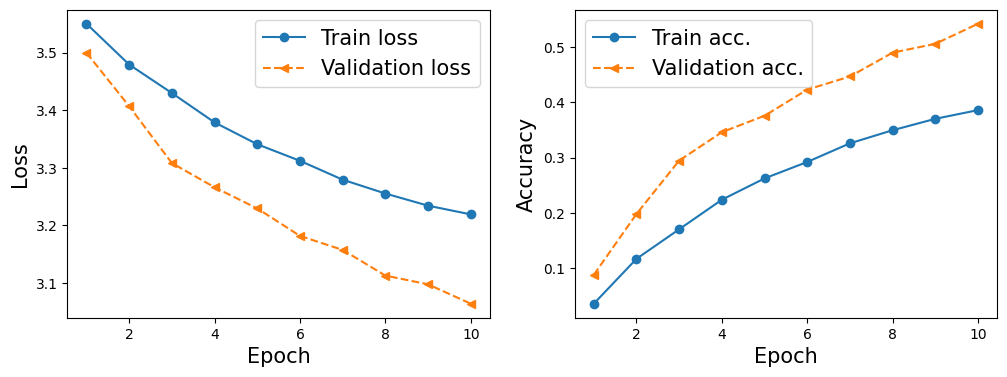

100%|██████████| 10/10 [02:33<00:00, 15.35s/it]


Parametry modelu: [[(96, 128, 128)], [(0.2, 0.2, 0.6)], [(12, 16, 16)], [(1, 1, 2)], [3]]


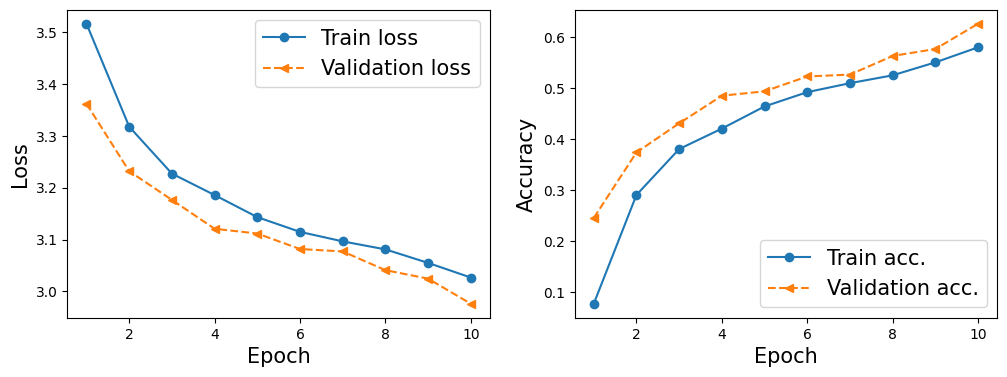

100%|██████████| 10/10 [02:35<00:00, 15.56s/it]


Parametry modelu: [[(96, 128, 128)], [(0.6, 0.6, 0.8)], [(16, 16, 16)], [(2, 2, 2)], [3]]


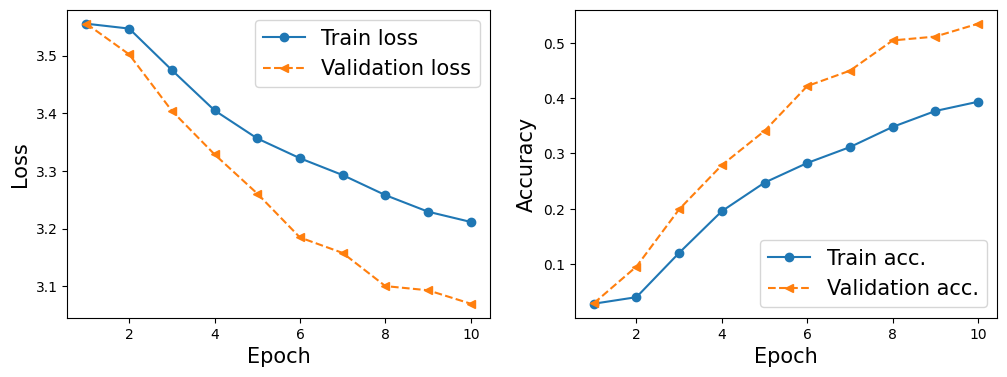

100%|██████████| 10/10 [02:30<00:00, 15.03s/it]


Parametry modelu: [[(96, 128, 192)], [(0.6, 0.6, 0.8)], [(12, 14, 14)], [(2, 2, 2)], [3]]


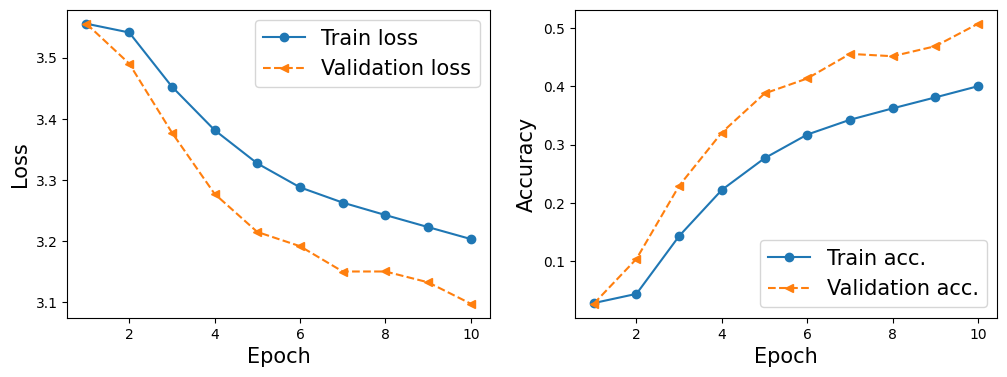

100%|██████████| 10/10 [02:34<00:00, 15.42s/it]


Parametry modelu: [[(96, 96, 128)], [(0.2, 0.2, 0.4)], [(12, 14, 16)], [(2, 2, 2)], [3]]


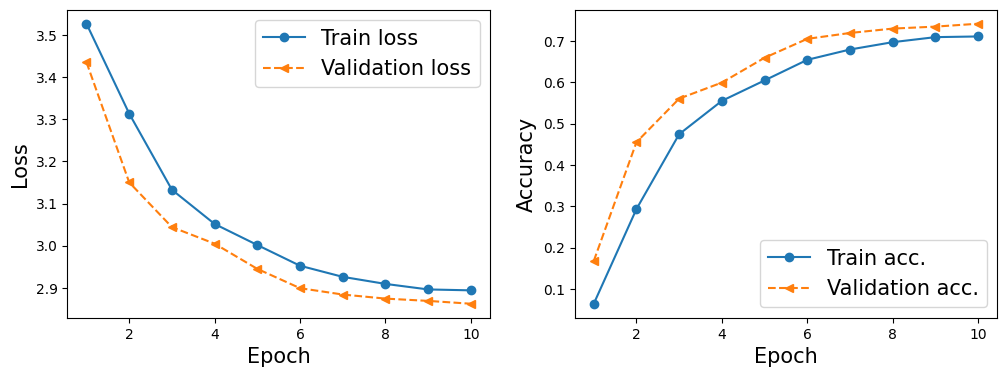

100%|██████████| 10/10 [02:40<00:00, 16.10s/it]


Parametry modelu: [[(128, 128, 128)], [(0.6, 0.6, 0.6)], [(12, 12, 16)], [(2, 2, 2)], [3]]


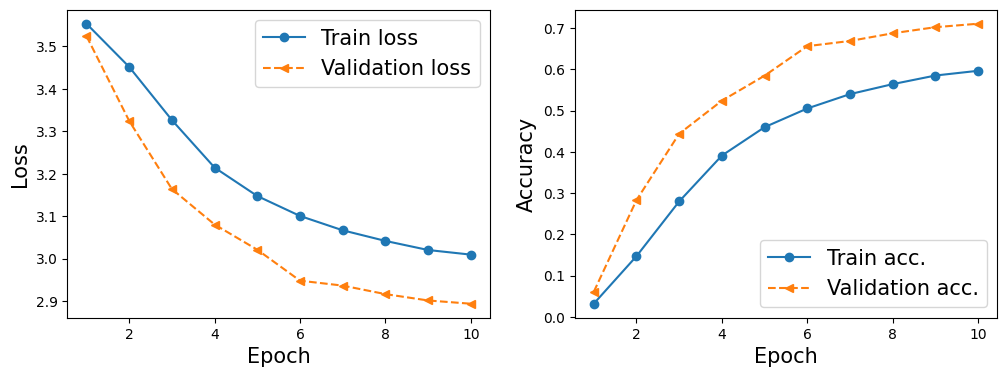

100%|██████████| 10/10 [02:48<00:00, 16.87s/it]


Parametry modelu: [[(128, 128, 128)], [(0.4, 0.4, 0.6)], [(12, 16, 16)], [(2, 2, 2)], [3]]


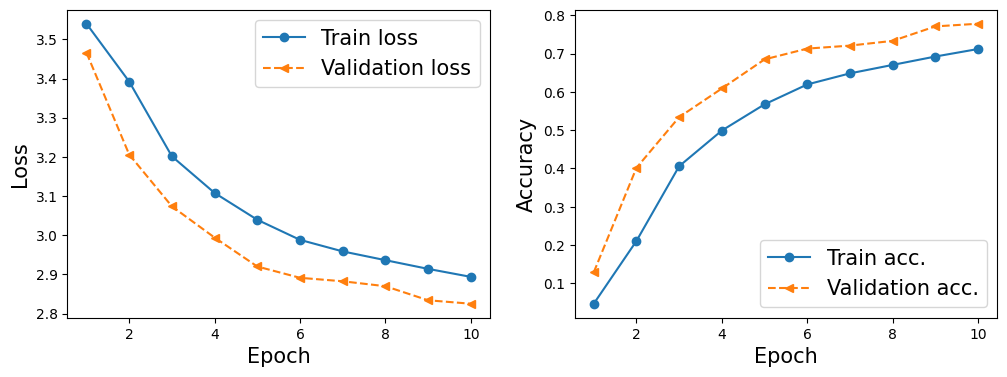

In [244]:
for i in range(10):
    model = Model_3(num_neurons, dropout_rates, num_channels, paddings)
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
    hist = train(model, num_epochs, train_dl, val_dl)

    x_arr = np.arange(len(hist[0])) + 1  
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15) 
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    print(f'Parametry modelu: {model.parameters_randomized}')

    

    plt.show()